# Import libraries

In [1]:
import gpytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from skimage.transform import resize

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydicom

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import random
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from layers.gaussian_process import PGLikelihood, SVGP_Model

# Hyperparameters and Constant

In [2]:
CHANNELS = 3
HEIGHT = 224
WIDTH = 224
SHAPE = (HEIGHT, WIDTH, CHANNELS)
DICOM_DIR = '../rsna-ich-mil/'

# Split dataset

In [3]:
def split_dataset_for_multilabel(X, multi_y, bag_names, test_size=0.15, val_size=0.25, random_state=42, num_classes=6, pos_label=0):
    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(X, multi_y))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = multi_y[train_idx], multi_y[test_idx]
        train_bag_names, test_bag_names = bag_names[train_idx], bag_names[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X_train, y_train))
        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]
        train_bag_names_final, val_bag_names = train_bag_names[train_idx], train_bag_names[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X, multi_y))
        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = multi_y[train_idx], multi_y[val_idx]
        train_bag_names_final, val_bag_names = bag_names[train_idx], bag_names[val_idx]
        X_test, y_test, test_bag_names = None, None, None

    return X_train_final, y_train_final, train_bag_names_final, X_val, y_val, val_bag_names, X_test, y_test, test_bag_names


def split_data(X, y, bag_names, test_size=0.15, val_size=0.15, random_state=42, num_classes=1, pos_label=0):
    if test_size > 0:
        # First split: train + test
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(sss.split(X, y[:, pos_label]))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        train_bag_names, test_bag_names = bag_names[train_idx], bag_names[test_idx]

        # Second split: train + validation
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X_train, y_train[:, pos_label]))

        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]
        train_bag_names_final, val_bag_names = train_bag_names[train_idx], train_bag_names[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X, y[:, pos_label]))

        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = y[train_idx], y[val_idx]
        train_bag_names_final, val_bag_names = bag_names[train_idx], bag_names[val_idx]
        X_test, y_test, test_bag_names = None, None, None

    return X_train_final, y_train_final, train_bag_names_final, X_val, y_val, val_bag_names, X_test, y_test, test_bag_names

# Attention

In [4]:
from layers.attention import MILAttentionLayer, GatedAttention

# Model

In [5]:
# Define the SVGP_MIL Model
class SVGP_MIL(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, num_ind=50):
        super(SVGP_MIL, self).__init__()

        self.dropout = nn.Dropout(0.25)
        self.gp_layer = nn.ModuleList([SVGP_Model(torch.rand(num_ind, 1)) for _ in range(NUM_CLASSES)])

        self.fc = nn.Linear(feature_dim + 1, 1)  # Fully connected layer
        self.att_layer = nn.ModuleList([MILAttentionLayer(feature_dim, hidden_dim) for _ in range(NUM_CLASSES)])
        self.fc_gp = nn.Linear(feature_dim, 1)

    def forward(self, x):
        output = []
        gp_output = []
        for i in range(NUM_CLASSES):
            attended_features, att_weights = self.att_layer[i](x)
            attended_features = self.dropout(attended_features)
            gp = self.gp_layer[i](self.fc_gp(attended_features))
            gp_output.append(gp)
            combine_feature = torch.cat([attended_features, gp.mean.unsqueeze(-1)], dim=-1)
            combine_feature = self.fc(combine_feature)
            output.append(combine_feature)
        output = torch.cat(output, dim=-1)

        return output, gp_output, att_weights

# Image Preprocessing

In [6]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x >= px_mode] = x[x >= px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation=cv2.INTER_LINEAR)

    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    # soft_img = window_image(dcm, 40, 380)
    soft_img = window_image(dcm, 30, 30)

    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    # soft_img = (soft_img - (-150)) / 380
    soft_img = (soft_img - 15) / 30

    if CHANNELS == 3:
        bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    else:
        bsb_img = brain_img

    return bsb_img.astype(np.float16)


def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        if CHANNELS == 3:
            return multichannel_slice.astype(np.float16)
        else:
            return slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice


# Dataset and DataLoader

In [7]:
# Define a custom Dataset
class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, features, multi_labels, bag_names):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.multi_labels = torch.tensor(multi_labels, dtype=torch.float32)
        print(f'Shape of multi_labels variables: {self.multi_labels.shape}')
        self.labels = self.multi_labels[:, SINGLE_LABEL_POS]
        self.bag_names = bag_names

    def __len__(self):
        return len(self.multi_labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.multi_labels[idx], self.bag_names[idx]

def load_data(csv_file, num_instances=57, test_size=0.2, random_state=42, dataset='rsna'):
    df = pd.read_csv(csv_file)

    # Group features by bag_name
    grouped = df.groupby('bag_name')

    # Prepare feature lists and label lists
    feature_list = []
    bag_label_list = []
    multi_label_list = []
    bag_name_list = []
    if dataset == 'cq500':
        multi_label_names = ['patient_ICH', 'patient_EDH', 'patient_IPH', 'patient_IVH', 'patient_SAH', 'patient_SDH']
    else:
        multi_label_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

    multi_label_names = multi_label_names[:NUM_CLASSES]

    for bag_name, group in grouped:
        # Extract features for the current bag
        feature_cols = [f'feature_{i}' for i in range(8)]
        features = group[feature_cols].values

        # Pad with zeros if the number of instances is less than num_instances
        if len(features) < num_instances:
            padding_size = num_instances - len(features)
            padding = np.zeros((padding_size, 8))
            features = np.vstack((features, padding))  # Vertically stack features and padding

        # Truncate if the number of instances is greater than num_instances
        elif len(features) > num_instances:
            features = features[:num_instances]

        feature_list.append(features)

        # Get the bag label for the current bag
        bag_label = group['bag_label'].values[0]
        bag_label_list.append(bag_label)

        # Store the bag name
        bag_name_list.append(bag_name)

        # Process multi-labels
        multi_labels = []
        for label in multi_label_names:
            # If any instance in the bag has the label, set it to 1
            label_value = 1 if (group[label] == 1).any() else 0
            multi_labels.append(label_value)
        multi_label_list.append(multi_labels)

    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(bag_label_list)
    multi_y = np.array(multi_label_list)
    bag_names = np.array(bag_name_list)

    return X, y, multi_y, bag_names

# Metrics

In [8]:
def calculate_metrics(y_true, y_pred, phase='val'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    average = 'weighted'
    if NUM_CLASSES == 1:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=1.0, average=average)
        recall = recall_score(y_true, y_pred, zero_division=1.0, average=average)
        f1 = f1_score(y_true, y_pred, zero_division=1.0, average=average)

    else:
        accuracy = np.mean((y_true == y_pred).mean(axis=0))
        precision, recall, f1 = [], [], []
        for i in range(NUM_CLASSES):
            precision.append(precision_score(y_true[:, i], y_pred[:, i], zero_division=1.0, average=average))
            recall.append(recall_score(y_true[:, i], y_pred[:, i], zero_division=1.0, average=average))
            f1.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=1.0, average=average))

        if phase == 'test':
            print(f"**Test Metrics for Each Class and Overall Average:**")
            print(f"{'Class':^5} {'Accuracy':^8} {'Precision':^9} {'Recall':^6} {'F1 Score':^8}")
            print("-" * 40)

            for i in range(NUM_CLASSES):
                accuracy_class = (y_true[:, i] == y_pred[:, i]).mean()
                print(f"{i:^5} {accuracy_class:^8.4f} {precision[i]:^9.4f} {recall[i]:^6.4f} {f1[i]:^8.4f}")

        # Calculate average metrics
        avg_accuracy = np.mean((y_true == y_pred).mean(axis=0))
        avg_precision = np.average(precision)
        avg_recall = np.average(recall)
        avg_f1 = np.average(f1)

        if phase == 'test':
            print(f"{'Avg':^5} {avg_accuracy:^8.4f} {avg_precision:^9.4f} {avg_recall:^6.4f} {avg_f1:^8.4f}")

    return {
        'partial_accuracy': np.average(accuracy),
        'precision': np.average(precision),
        'recall': np.average(recall),
        'f1': np.average(f1)
    }

# Training and evaluation

In [9]:
def train(model, dataloader, optimizer, criterion, device, likelihood, var_optimizer, mlls, num_classes, threshold, use_likelihood=False, alpha=0.5):
    model.train()
    likelihood.train()
    epoch_loss = 0
    all_labels, all_preds = [], []

    with gpytorch.settings.num_likelihood_samples(100):
        for features, labels, multi_labels, _ in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            optimizer.zero_grad()
            for opt in var_optimizer:
                opt.zero_grad()

            predictions, gp_output, _ = model(features)
            loss = calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes, alpha)

            loss.backward()
            optimizer.step()
            for opt in var_optimizer:
                opt.step()

            epoch_loss += loss.item()
            probs = get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood)
            preds = (probs >= threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(multi_labels.cpu().numpy() if num_classes > 1 else labels.cpu().numpy())

    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss / len(dataloader), metrics['partial_accuracy'], metrics['precision'], metrics['recall'], metrics['f1']

def evaluate(model, dataloader, criterion, device, likelihood, mlls, num_classes, threshold, use_likelihood=False, phase='val', alpha=0.5):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for features, labels, multi_labels, _ in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            predictions, gp_output, _ = model(features)
            loss = calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes, alpha)

            epoch_loss += loss.item()
            probs = get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood)
            preds = (probs >= threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(multi_labels.cpu().numpy() if num_classes > 1 else labels.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

    metrics = calculate_metrics(all_labels, all_preds, phase=phase)
    cohen_kappa = cohen_kappa_score(all_labels, all_preds) if num_classes == 1 else 0

    return (epoch_loss / len(dataloader), metrics['partial_accuracy'], metrics['precision'],
            metrics['recall'], metrics['f1'], cohen_kappa, all_labels, all_scores)

def get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood):
    if use_likelihood:
        # return torch.stack([likelihood[i](gp_output[i]).probs for i in range(num_classes)], dim=-1)
        probs = [likelihood[i](gp_output[i]).probs for i in range(num_classes)]
        return torch.stack(probs, dim=1)
    else:
        return torch.sigmoid(predictions)

def calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes, alpha=0.5):
    gp_loss = 0.0
    for i, (mll, gp) in enumerate(zip(mlls, gp_output)):
        gp_loss += -mll(gp, multi_labels[:, i])

    total_loss = (criterion(predictions.squeeze(-1), multi_labels[:, SINGLE_LABEL_POS]) if num_classes == 1
                 else criterion(predictions, multi_labels)) * (1 - alpha) + gp_loss * alpha
    total_loss = total_loss.mean()
    return total_loss

# Visualization

## Metrics Visualization

In [10]:
def plot_roc_auc(y_true, y_scores, class_names=None):
    plt.figure(figsize=(10, 8))

    if class_names is None:  # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
        roc_auc_values = [roc_auc]
    else:  # Multi-label classification
        roc_auc_values = []
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
            roc_auc_values.append(roc_auc)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc_values

def plot_pr_curve(y_true, y_scores, class_names=None):
    plt.figure(figsize=(10, 8))

    if class_names is None:  # Binary classification
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auc_pr = auc(recall, precision)
        plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.4f}')
        auc_pr_values = [auc_pr]
    else:  # Multi-label classification
        auc_pr_values = []
        for i, class_name in enumerate(class_names):
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
            auc_pr = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC = {auc_pr:.2f})')
            auc_pr_values.append(auc_pr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return auc_pr_values

def plot_confusion_matrix(y_true, y_pred, class_names=None, threshold=0.5):
    if class_names is None:  # Binary classification
        y_pred_binary = (y_pred >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
    else:  # Multi-label classification
        n_classes = len(class_names)
        fig, axes = plt.subplots(2, 3, figsize=(20, 15))
        axes = axes.ravel()

        for i in range(n_classes):
            cm = confusion_matrix(y_true[:, i], (y_pred[:, i] >= threshold).astype(int))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_xlabel('Predicted labels')
            axes[i].set_ylabel('True labels')
            axes[i].set_title(f'Confusion Matrix - {class_names[i]}')

        plt.tight_layout()

    plt.show()

## Attention weights visualization

In [11]:
def get_instance_images(bag_name, csv_file):
    df = pd.read_csv(csv_file)
    # Filter the DataFrame by the specified bag_name
    bag_data = df[df['bag_name'] == bag_name]
    if not bag_data.empty:
        instance_names = bag_data['instance_name'].tolist()

        # Find folders containing the bag_name in DICOM_DIR
        folders = [f for f in os.listdir(DICOM_DIR) if bag_name[3:] in f] # bag_name[3:] to remove ID_
        if folders:
            folder_path = os.path.join(DICOM_DIR, folders[0])
            # Check if all instance names exist in the folder
            existing_files = os.listdir(folder_path)
            if all(instance_name in existing_files for instance_name in instance_names):
                images = []
                z_coords = []
                for instance_name in instance_names:
                    # Construct the full path to the image file
                    image_path = os.path.join(folder_path, instance_name)
                    dcm = pydicom.dcmread(image_path)
                    z_coord = dcm.ImagePositionPatient[2]  # Extract Z-coordinate
                    z_coords.append(z_coord)
                    processed_image = preprocess_slice(dcm)
                    images.append(processed_image)

                # Sort images by Z-coordinate
                sorted_indices = np.argsort(z_coords)
                sorted_images = np.array([images[i] for i in sorted_indices])

                return sorted_images
            else:
                print(f"Not all instance names found for bag name '{bag_name}'")
                return []
        else:
            print(f"No folder found containing bag name '{bag_name}'")
            return []
    else:
        print(f"No instances found for bag name '{bag_name}'")
        return []

def scale_attention_weights(attention_weights, patient_labels):
    if patient_labels == 0:
        # If patient label is 0, set all attention weights to 0
        scaled_attention_weights = np.array([[0.0] * len(attention_weights)])
        scaled_attention_weights = scaled_attention_weights[0]  # Convert to original shape
    elif patient_labels == 1:
        # If patient label is 1, scale attention weights to range [0, 1]
        min_weight = np.min([w[0] for w in attention_weights])
        max_weight = np.max([w[0] for w in attention_weights])
        scaled_attention_weights = np.array([[((w[0] - min_weight) / (max_weight - min_weight)) if max_weight != min_weight else 1 for w in attention_weights]])
        scaled_attention_weights = scaled_attention_weights[0]  # Convert back to original shape
    else:
        raise ValueError("Patient label must be either 0 or 1")

    return scaled_attention_weights

def plot_patient_images(bag_name, csv_file, attention_weights, patient_labels):
    instance_images = get_instance_images(bag_name, csv_file=csv_file)
    if instance_images is not None and instance_images.any():
        # Ensure images are in float32 format
        instance_images = instance_images.astype(np.float32)

        # Determine the number of rows and columns for plotting
        num_images = len(instance_images)
        num_cols = 6  # Plot 6 images per row
        num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

        # Create a figure with subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
        # Set the title of the plot
        fig.suptitle(f"Patient Labels: {patient_labels}")

        # Scale attention weights
        scaled_attention_weights = scale_attention_weights(attention_weights, patient_labels)
        # Iterate over images and plot them
        for i, (image, ax) in enumerate(zip(instance_images, axs.flatten())):
            # Ensure image values are in the range [0, 1] for plotting
            image = np.clip(image, 0, 1)
            ax.imshow(image, cmap='gray')
            ax.axis('off')  # Turn off axis

            # Highlight scaled attention weights
            if NUM_CLASSES == 1:
                # Single label, attention weights are uniform across images
                scaled_attention_weight = scaled_attention_weights[i]
                ax.set_title(f"Weight: {scaled_attention_weight:.2f}")
            else:
                # Multi-label, attention weights are per class
                scaled_attention_weights_for_image = scaled_attention_weights[i]
                ax.set_title(f"Weights: {', '.join(f'{w[0]:.2f}' for w in scaled_attention_weights_for_image)}")

        # Hide unused subplots
        for i in range(num_images, num_rows * num_cols):
            axs.flatten()[i].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        print(f"No images found for bag name '{bag_name}'")

def evaluate_and_plot(model, dataloader, criterion, device, likelihood, mlls, num_classes, threshold, use_likelihood=False, phase='test', alpha=0.5, csv_file=None):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for features, labels, multi_labels, bag_names in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            predictions, gp_output, att_weights = model(features)
            loss = calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes, alpha)

            epoch_loss += loss.item()
            probs = get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood)
            preds = (probs >= threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(multi_labels.cpu().numpy() if num_classes > 1 else labels.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

            # Plot images for labels 0 and 1
            for label in [0, 1]:
                indices = np.where(labels.cpu().numpy() == label)[0]
                if len(indices) > 0:
                    index = indices[0]  # Select the first instance with the current label
                    bag_name = bag_names[index]
                    att_weights_for_label = att_weights[index].cpu().numpy()
                    multi_labels_for_label = multi_labels[index].cpu().numpy()
                    plot_patient_images(bag_name, csv_file, att_weights_for_label, multi_labels_for_label)
            break

# Set up

In [12]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_data_loaders(X_train, y_train, train_bag_names, X_val, y_val, val_bag_names, X_test, y_multi_test, test_bag_names, batch_size):
    train_dataset = MedicalDataset(X_train, y_train, train_bag_names)
    val_dataset = MedicalDataset(X_val, y_val, val_bag_names)
    test_dataset = MedicalDataset(X_test, y_multi_test, test_bag_names)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def setup_model_and_optimizer(feature_dim, hidden_dim, output_dim, X_train, y_train, device, learning_rate, num_classes, num_ind=50):
    model = SVGP_MIL(feature_dim, hidden_dim, output_dim, num_ind=num_ind).to(device)
    likelihood = nn.ModuleList([PGLikelihood().to(device) for _ in range(num_classes)])
    mlls = nn.ModuleList([gpytorch.mlls.VariationalELBO(likelihood[i], model.gp_layer[i], num_data=len(X_train)) for i in range(num_classes)])
    mlls = [mll.to(device) for mll in mlls]
    variational_ngd_optim = [gpytorch.optim.NGD(model.gp_layer[i].variational_parameters(), num_data=len(X_train), lr=0.01) for i in range(num_classes)]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f'Len of X_train: {len(X_train)}')

    return model, likelihood, mlls, variational_ngd_optim, optimizer

# Main function

In [13]:
def main(train_file, test_file, hidden_dim=64, learning_rate=0.00005, batch_size=16, num_epochs=100, num_instances=57, use_likelihood=False, alpha=0.5, num_ind=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load and prepare data
    X_train, y_train, y_multi_train, train_bag_names = load_data(train_file, num_instances=num_instances)
    num_instances_for_test = 32 if 'cq500' in test_file else num_instances
    dataset = 'cq500' if 'cq500' in test_file else 'rsna'
    X_test, y_test, y_multi_test, test_bag_names = load_data(test_file, num_instances=num_instances_for_test, dataset=dataset)
    split_func = split_dataset_for_multilabel if NUM_CLASSES > 1 else split_data
    X_train, y_train, train_bag_names, X_val, y_val, val_bag_names, _, _, _ = split_func(X_train, y_multi_train, train_bag_names, test_size=0.0, val_size=0.25, random_state=42, num_classes=NUM_CLASSES, pos_label=SINGLE_LABEL_POS)

    # Setup data loaders
    train_loader, val_loader, test_loader = setup_data_loaders(X_train, y_train, train_bag_names, X_val, y_val, val_bag_names, X_test, y_multi_test, test_bag_names, batch_size)

    # Setup model and optimizer
    feature_dim = X_train.shape[2]
    output_dim = 1
    model, likelihood, mlls, variational_ngd_optim, optimizer = setup_model_and_optimizer(feature_dim, hidden_dim, output_dim, X_train, y_train, device, learning_rate, NUM_CLASSES, num_ind)

    # Setup loss function
    pos_weights = torch.tensor(([2.0] * NUM_CLASSES) if NUM_CLASSES > 1 else [2.0], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    # Training loop
    best_acc = 0
    best_model = None
    best_likelihood = None
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device, likelihood, variational_ngd_optim,mlls, NUM_CLASSES, threshold=0.5, use_likelihood=use_likelihood, alpha=alpha)
        val_loss, val_acc, val_precision, val_recall, val_f1, val_co_kappa, val_labels, val_scores = evaluate(model, val_loader, criterion, device, likelihood, mlls, NUM_CLASSES, THRESHOLD, phase='val', use_likelihood=use_likelihood, alpha=alpha)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}')
        print(f'Validation: Loss={val_loss:.4f}, Acc={val_acc:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}\n')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()
            best_likelihood = likelihood.state_dict()

    print(f'Best val accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model)
    likelihood.load_state_dict(best_likelihood)

    # Evaluate on test set
    test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls, NUM_CLASSES, THRESHOLD, phase='test', use_likelihood=use_likelihood)
    print(f'Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}, Cohen Kappa={test_co_kappa:.4f}')

    # Plot performance curves
    if NUM_CLASSES == 1:
        test_labels, test_scores = np.array(test_labels), np.array(test_scores)
        test_auc = plot_roc_auc(test_labels, test_scores)
        test_auc_pr = plot_pr_curve(test_labels, test_scores)
        plot_confusion_matrix(test_labels, test_scores)
    else:
        class_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        class_names = class_names[:NUM_CLASSES]
        test_labels, test_scores = np.array(test_labels), np.array(test_scores)
        test_auc = plot_roc_auc(test_labels, test_scores, class_names)
        test_auc_pr = plot_pr_curve(test_labels, test_scores, class_names)
        plot_confusion_matrix(test_labels, test_scores, class_names)

    # Plot
    evaluate_and_plot(model, test_loader, criterion, device, likelihood, mlls, NUM_CLASSES, THRESHOLD, use_likelihood, phase='test', alpha=alpha, csv_file=test_file)

    return test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_auc, test_auc_pr

# Main

Shape of multi_labels variables: torch.Size([750, 1])
Shape of multi_labels variables: torch.Size([250, 1])
Shape of multi_labels variables: torch.Size([150, 1])
Len of X_train: 750
Starting training...
Epoch 1/20:
Train: Loss=-0.1936, Acc=0.7933, Precision=0.8033, Recall=0.7933, F1=0.7949
Validation: Loss=-0.4009, Acc=0.9320, Precision=0.9344, Recall=0.9320, F1=0.9313

Epoch 2/20:
Train: Loss=-0.2554, Acc=0.8200, Precision=0.8241, Recall=0.8200, F1=0.8210
Validation: Loss=-0.4348, Acc=0.9360, Precision=0.9380, Recall=0.9360, F1=0.9354

Epoch 3/20:
Train: Loss=-0.2353, Acc=0.7880, Precision=0.7946, Recall=0.7880, F1=0.7894
Validation: Loss=-0.4458, Acc=0.9320, Precision=0.9344, Recall=0.9320, F1=0.9313

Epoch 4/20:
Train: Loss=-0.2660, Acc=0.8133, Precision=0.8172, Recall=0.8133, F1=0.8143
Validation: Loss=-0.4569, Acc=0.9360, Precision=0.9380, Recall=0.9360, F1=0.9354

Epoch 5/20:
Train: Loss=-0.3024, Acc=0.8293, Precision=0.8354, Recall=0.8293, F1=0.8304
Validation: Loss=-0.4738, Acc

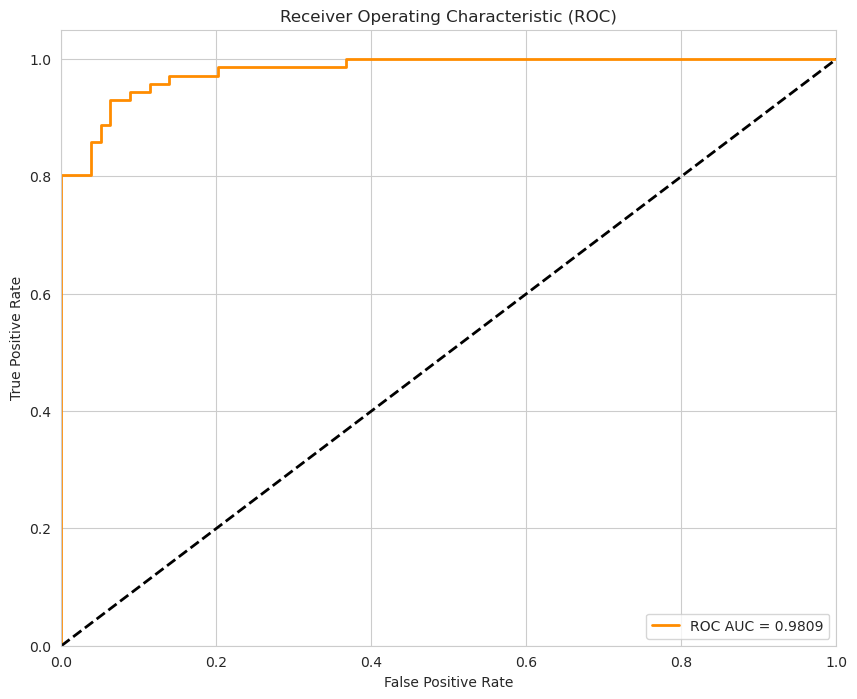

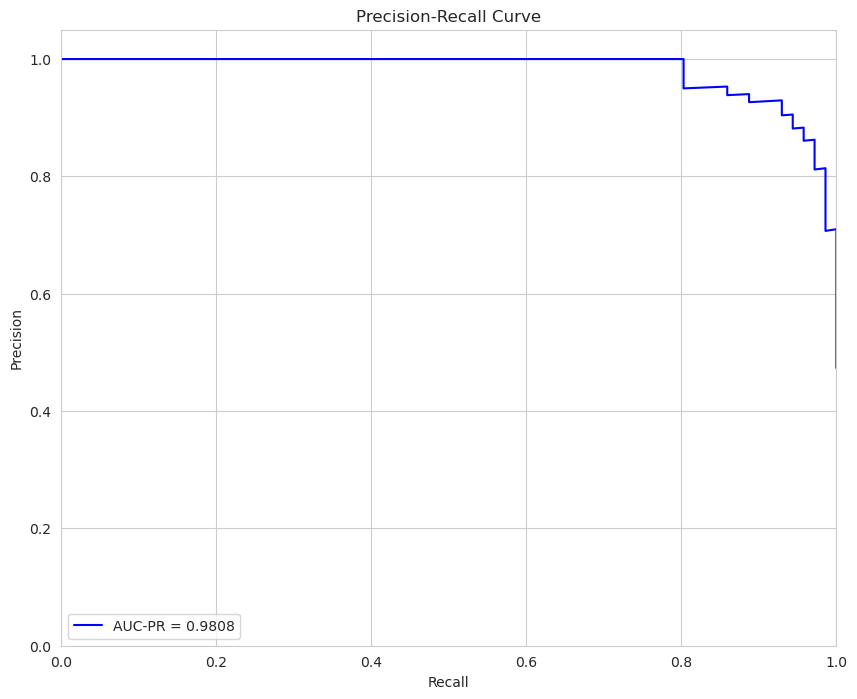

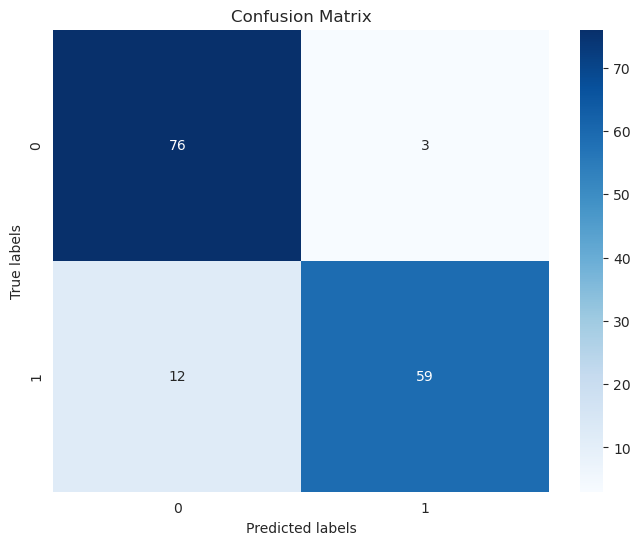

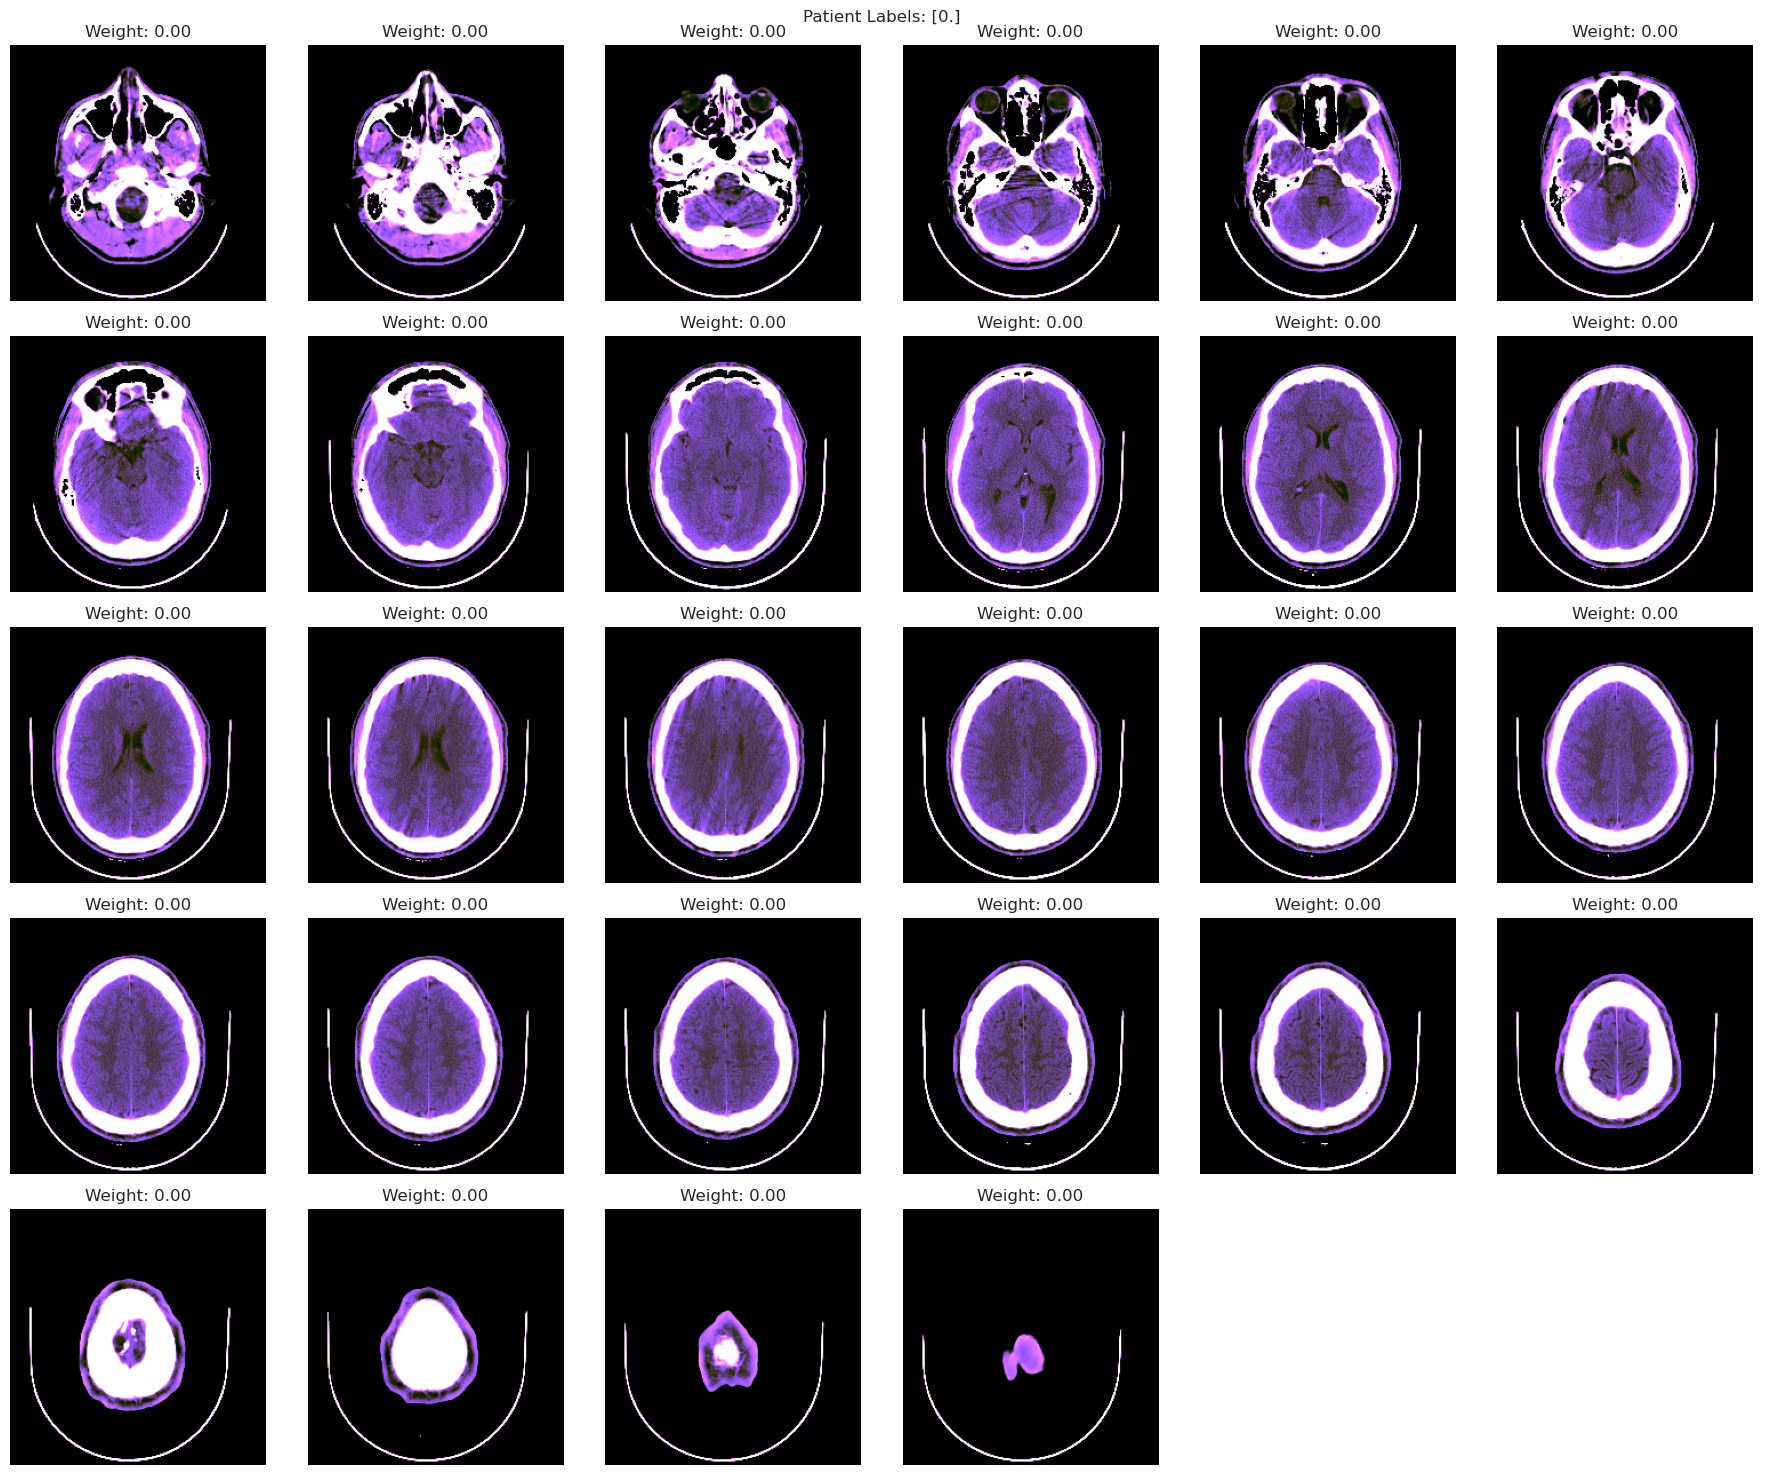

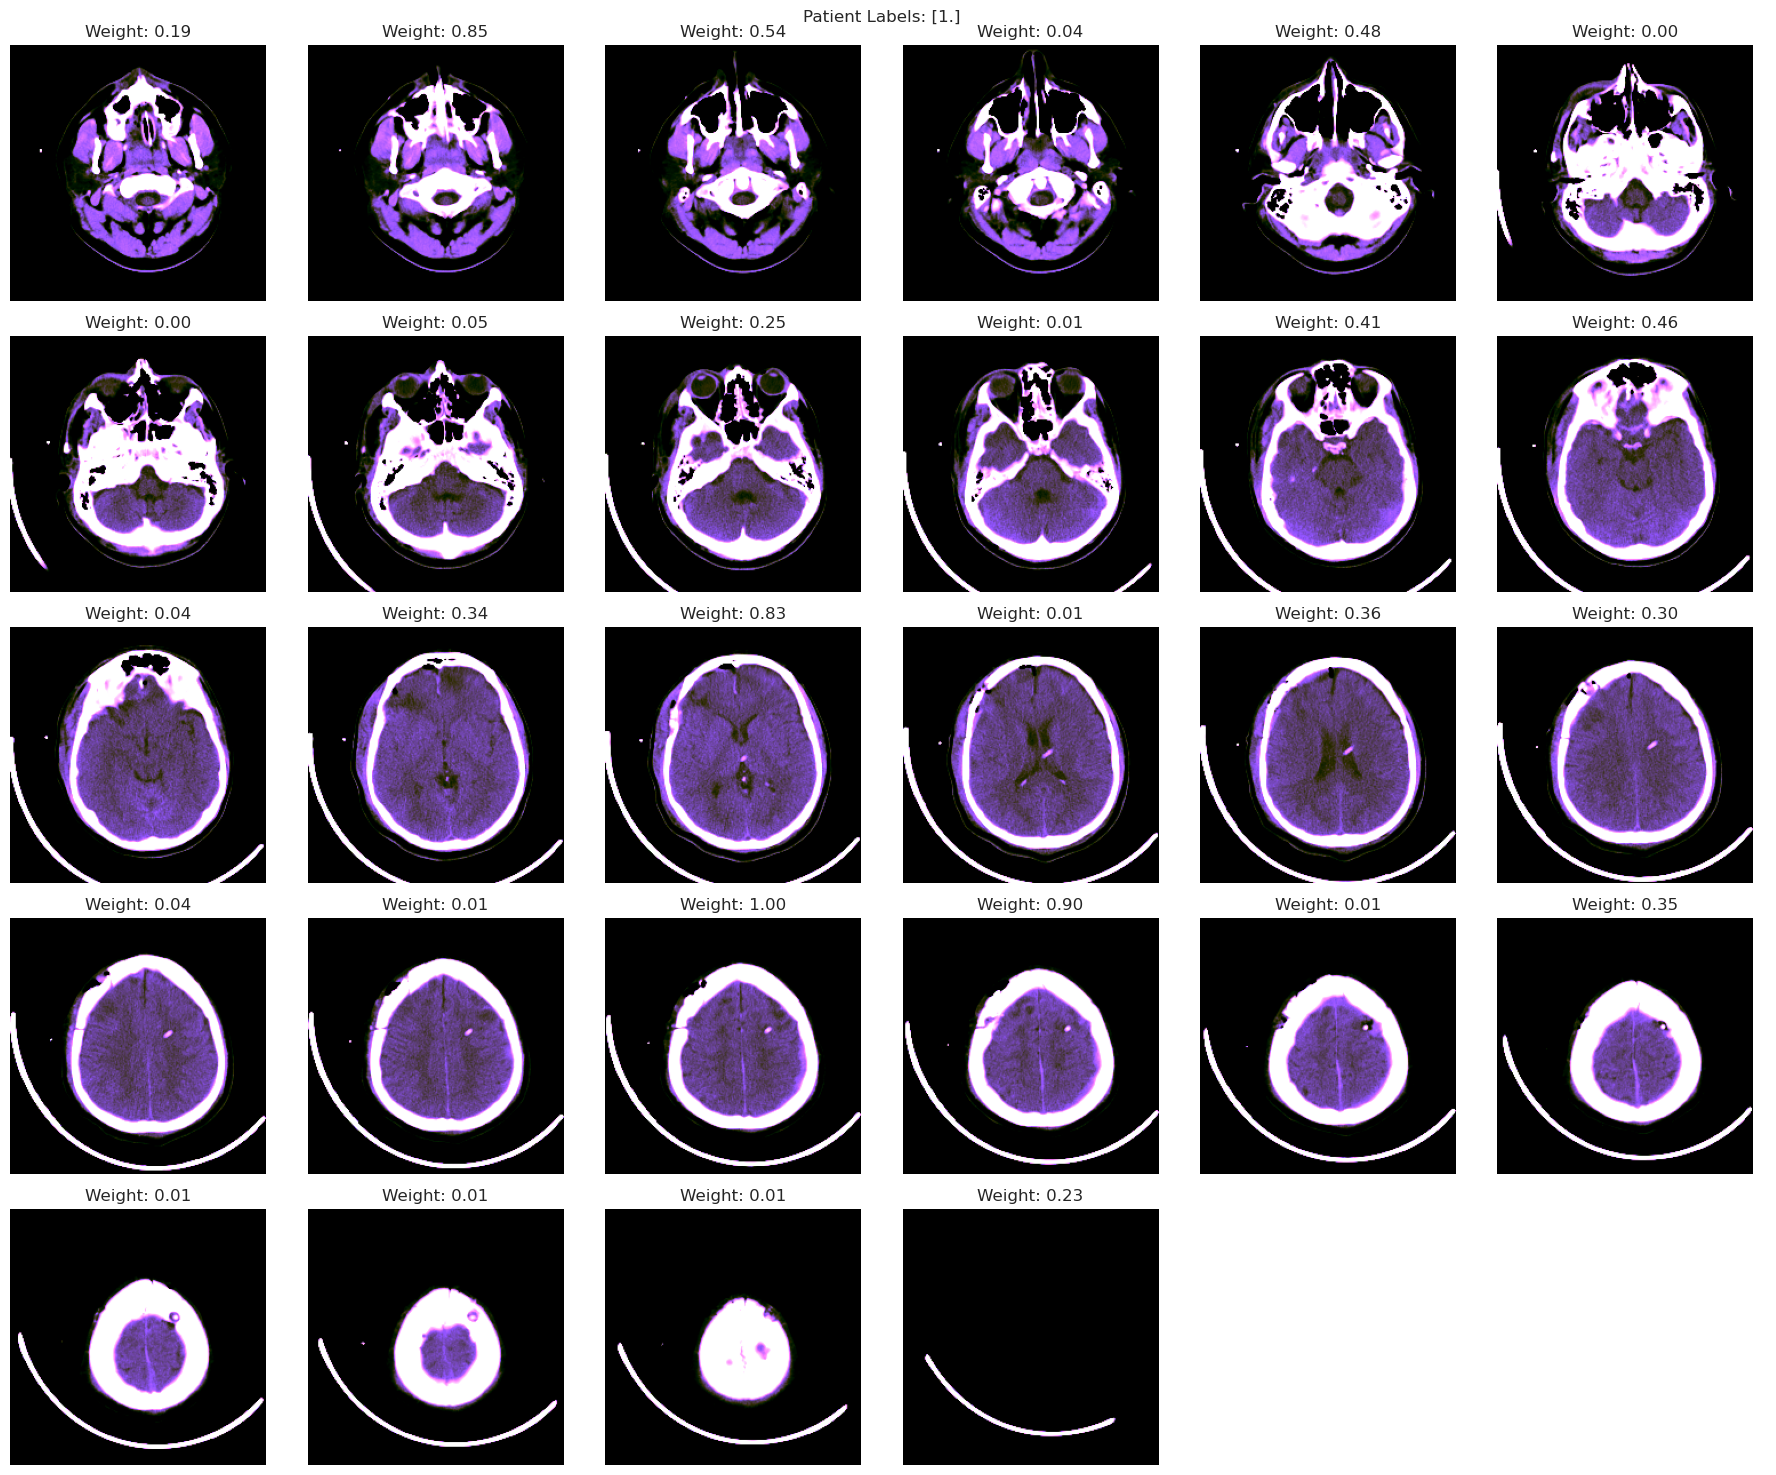

Accuracy: Mean = 0.9000, Std = 0.0000
Precision: Mean = 0.9053, Std = 0.0000
Recall: Mean = 0.9000, Std = 0.0000
F1: Mean = 0.8993, Std = 0.0000
Cohen Kappa: Mean = 0.7981, Std = 0.0000
ROC-AUC: Mean = 0.9809, Std = 0.0000
AUC-PR: Mean = 0.9808, Std = 0.0000


In [14]:
if __name__ == "__main__":
    NUM_CLASSES = 1
    THRESHOLD = 0.5
    SINGLE_LABEL_POS = 0
    USE_LIKELIHOOD = True
    seed_everything(seed=42)
    ALPHA = 1
    NUM_IND = 150

    # train_files = ['rsna_train_0_redundancy.csv', 'rsna_train_1_redundancy.csv', 'rsna_train_2_redundancy.csv', 'rsna_train_3_redundancy.csv', 'rsna_train_4_redundancy.csv']
    # test_files = ['rsna_test_0_redundancy.csv', 'rsna_test_1_redundancy.csv', 'rsna_test_2_redundancy.csv', 'rsna_test_3_redundancy.csv', 'rsna_test_4_redundancy.csv']
    train_files = ['rsna_train_0_redundancy.csv']
    test_files = ['rsna_test_0_redundancy.csv']
    # test_files = ['cq500_test_0_redundancy.csv', 'cq500_test_1_redundancy.csv', 'cq500_test_2_redundancy.csv', 'cq500_test_3_redundancy.csv', 'cq500_test_4_redundancy.csv']
    # train_files = ['rsna_train_0_update.csv', 'rsna_train_1_update.csv', 'rsna_train_2_update.csv', 'rsna_train_3_update.csv', 'rsna_train_4_update.csv']
    # test_files = ['rsna_test_0_update.csv', 'rsna_test_1_update.csv', 'rsna_test_2_update.csv', 'rsna_test_3_update.csv', 'rsna_test_4_update.csv']
    # train_files = ['data/cv_data/val_features.csv']
    # test_files = ['data/cv_data/test_features.csv']
    # train_files = ['data/rsna/rsna_train_0_redundancy.csv']
    # test_files = ['data/rsna/rsna_test_0_redundancy.csv']
    all_results = []
    all_auc_results = []
    all_auc_pr_results = []
    for train_file, test_file in zip(train_files, test_files):
        train_file = f'./data/rsna/{train_file}'
        test_file = f'./data/rsna/{test_file}'
        results = main(train_file, test_file, num_instances=28, learning_rate=0.00005, batch_size=16, num_epochs=20, use_likelihood=USE_LIKELIHOOD, alpha=ALPHA, num_ind=NUM_IND)
        all_results.append(results[:5])
        all_auc_results.append(results[5])
        all_auc_pr_results.append(results[6])

    # Calculate and print mean and std for scalar metrics
    all_results = np.array(all_results)
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Cohen Kappa']
    for i, metric in enumerate(metrics):
        print(f'{metric}: Mean = {mean_results[i]:.4f}, Std = {std_results[i]:.4f}')

    # Handle AUC metrics separately
    if NUM_CLASSES == 1:
        print(f'ROC-AUC: Mean = {np.mean(all_auc_results):.4f}, Std = {np.std(all_auc_results):.4f}')
        print(f'AUC-PR: Mean = {np.mean(all_auc_pr_results):.4f}, Std = {np.std(all_auc_pr_results):.4f}')
    else:
        # For multi-class, you might want to average across classes first
        mean_auc = np.mean([np.mean(auc) for auc in all_auc_results])
        std_auc = np.std([np.mean(auc) for auc in all_auc_results])
        mean_auc_pr = np.mean([np.mean(auc_pr) for auc_pr in all_auc_pr_results])
        std_auc_pr = np.std([np.mean(auc_pr) for auc_pr in all_auc_pr_results])
        print(f'ROC-AUC: Mean = {mean_auc:.4f}, Std = {std_auc:.4f}')
        print(f'AUC-PR: Mean = {mean_auc_pr:.4f}, Std = {std_auc_pr:.4f}')

# Visualization